In [1]:
import splat
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import numba
from tqdm import tqdm
%matplotlib inline

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


In [8]:
s= wisps.Source(filename='par32-00075')

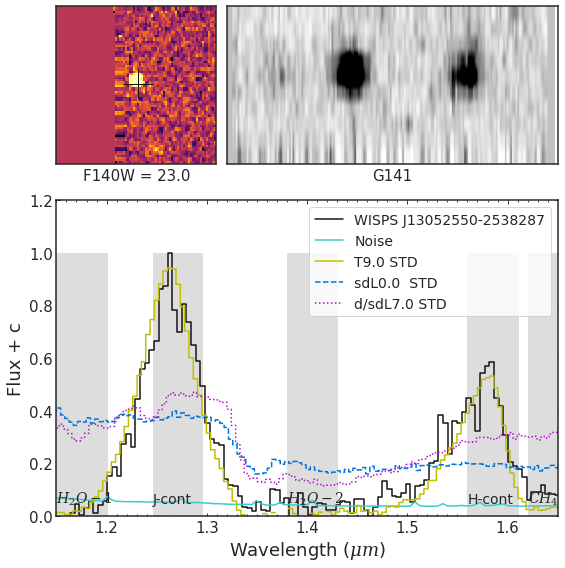

In [9]:
s.plot(compare_to_sds=True, comprange=[[1.15, 1.6]])

In [4]:
s.distance

{'val': <Quantity 830.3498776 pc>,
 'er': <Quantity [393.1487342 , 216.62686913] pc>}

In [5]:
ghvj

NameError: name 'ghvj' is not defined

In [ ]:
exclude=[]

In [ ]:
len(splat.searchLibrary(vlm=True, giant=False, subdwarf=True, spt=[15, 29], young=False))

In [ ]:
len(splat.searchLibrary(vlm=True, giant=False, subdwarf=True, metallicity_class='sd', spt=[15, 29]))

In [ ]:
#remove object from forbidden list
splat_db0=splat.searchLibrary(vlm=True, giant=False, subdwarf=True, spt=[15, 29], young=False)
splat_db0['SHORTNAME']=splat_db0.DESIGNATION.apply(splat.designationToShortName)
splat_db=splat_db0[~splat_db0.SHORTNAME.isin(wisps.FORBIDDEN_LIST)].reset_index(drop=True)

In [ ]:
splat_within_snr=splat_db[splat_db.MEDIAN_SNR.between(5, 200)]

In [ ]:
def create_splat_source(filename):
    try:
        #create a wisps spectrum
        #retrieve splat spectrum

        splat_s=splat.getSpectrum(filename=filename)[0]
        #trim
        #splat_s.trim([1.1, 1.7])
        
        #spt=splat.typeToNum(splat_s.spex_type)
        #splat_s.toInstrument('WFC3-G141')

        #create a source object
        s=wisps.Spectrum( 
                       wave=splat_s.wave.value, 
                       flux=splat_s.flux.value,
                      noise=splat_s.noise.value,
                      contam= np.zeros(len(splat_s.wave.value)))
        
        #put it on wisps resolution
        
        s._splat_spectrum=splat_s

        s.normalize()
        return s 
    except OSError:
        return 
    

In [ ]:
#splat_within_snr.head(5)

In [ ]:
%%capture
tqdm.pandas()
spectra=splat_within_snr.DATA_FILE.progress_apply(create_splat_source)

In [ ]:
len(splat_within_snr)

In [ ]:
splat.STDS_DWARF_SPEX.keys()

In [ ]:
splat.STDS_DSD_SPEX.keys()

In [ ]:
splat.STDS_DWARF_SPEX.keys()

In [ ]:
EXCLUDE=['J05585891-2903267', 'J10462067+2354307', 'J1252301-432155',  'J14270666+4808164',\
        'J16130315+6502051', 'J21225635+3656002', 'J00180652+2853259', 'J00255117-0748069', \
         'J00524886+1712434', 'J01002474+171127', 'J01572792+0116433', 'J02243259+1730043', 
         'J03301720+3505001','J03303847-2348463', 'J04024315+1730136', 'J04520994-2245084', 
        'J06095784+6954460', 'J08305161+3612577', 'J23311819+460727', 'J2325168-043101', 
         'J22211039-1958053', 'J13312833+2447114', 'J1227050-0447207', 'J04470652-1946392',
         'J00554418+2506235', 'J01012732+3521529', 'J02064420-242826', 'J02193629-2639526',
         'J07212276+0308490',  'J07522108+1809283', 'J10130734-1356204', 'J09042301+4638192', 
        'J10153992+4758285', 'J10171562+4654066', 'J11181466+0941131', 'J12053656+1513229', \
         'J12182812+1325080', 'J12341578+2037054', 'J13035292+5115064', 'J13133115+3322468',
        'J15281990+2221148', 'J15225932-0244530', 'J23311819+4607273', 'J23295021+5055528', 
        'J15202948+1434391', 'J0148-4225', 'J02064420-2428267', 'J02320825-4437059',\
         'J12274209+2512586', 'J13512862+5506575','J00575764+2013040', 'J22314276-3451471', \
         'J0720341-490235']

In [ ]:
def plot_sp_sp(s, a, shortname, spt):
    
    std=splat.STDS_DWARF_SPEX[spt]
    _, scale=splat.compareSpectra(s.splat_spectrum, std,  comprange=[[0.8, 1.3]], statistic='chisqr', scale=True) 
    std.scale(scale)
    xlim=[0.8, 2.5 ]
    mask= np.logical_and(s.wave>xlim[0],  s.wave<xlim[-1])
    a.plot(s.wave, s.flux, label=shortname,linewidth=3, c='k')
    a.plot(std.wave.value, std.flux.value, linestyle='--', label='{} std'.format(spt),\
           alpha=0.5)
    sd_std=None
    try:
        sd_type, _= splat.classifyByStandard(s.splat_spectrum, comprange=[[0.8, 1.3]], sd=True)
        sd_std=splat.STDS_SD_SPEX[sd_type]
        _, sd_scale=splat.compareSpectra(s.splat_spectrum, sd_std,  comprange=[[0.8, 1.3]], statistic='chisqr', scale=True) 
        sd_std.scale(sd_scale)
        a.plot(sd_std.wave.value, sd_std.flux.value, linestyle='-.', label='{}  std'.format(sd_type),\
           alpha=0.5)
    except KeyError:
        pass
    
   
    
    d_sd_std=None
    try:
        dsd_type, _= splat.classifyByStandard(s.splat_spectrum, comprange=[[0.8, 1.3]], dsd=True)
        d_sd_std=splat.STDS_DSD_SPEX[dsd_type]
        _, d_sd_scale=splat.compareSpectra(s.splat_spectrum, d_sd_std,  comprange=[[0.8, 1.3]], statistic='chisqr', scale=True) 
        d_sd_std.scale(d_sd_scale)
        a.plot(d_sd_std.wave.value, d_sd_std.flux.value, linestyle=':', label='{} std'.format(dsd_type),\
           alpha=0.5)
    except KeyError:
        pass
    
    
    #a.set_title("{} ".format(s.spectral_type ))
    a.legend(fontsize=10)
    a.set(ylim=[np.nanmin(s.flux[mask]), np.nanmax(s.flux[mask])], xlim=xlim)
    if shortname in EXCLUDE:
        a.plot([0, 1], [0, 1], transform=a.transAxes, color='r')
        a.plot([1, 0], [0, 1], transform=a.transAxes, color='r')




In [ ]:
def make_wisps(splat_s):
    try:
        s=wisps.Spectrum(wave=splat_s.wave.value, 
                           flux=splat_s.flux.value,
                          noise=splat_s.noise.value)
        return s
    except:
        return 

In [ ]:
fdf=pd.DataFrame()
fdf['spectra']=spectra
fdf['shortname']=splat_within_snr.SHORTNAME
fdf['designation']=splat_within_snr.DESIGNATION
fdf['spex_type']=splat_within_snr.SPEX_TYPE
fdf['opt_type']=splat_within_snr.OPT_TYPE

In [ ]:
fdf=fdf.dropna(subset=['spectra'])

In [ ]:
len(splat_within_snr.OPT_TYPE), len(splat_within_snr)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
%%capture
with PdfPages(wisps.OUTPUT_FIGURES+'/multipage_subdwarf.pdf') as pdf:
    
    for g in np.array_split(fdf, int(len(fdf)/4)):
        fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(12, 6))
       
        
        plot_sp_sp(g.spectra.iloc[0], ax[0][0], g.designation.iloc[0],\
                   g.spex_type.iloc[0])
        plot_sp_sp(g.spectra.iloc[1], ax[0][1],  g.designation.iloc[1], \
                   g.spex_type.iloc[1])
        plot_sp_sp(g.spectra.iloc[2], ax[1][0],  g.designation.iloc[2],\
                  g.spex_type.iloc[2])
        plot_sp_sp(g.spectra.iloc[3], ax[1][1],  g.designation.iloc[3],\
                   g.spex_type.iloc[3])

        pdf.savefig() 
        plt.close()

In [ ]:
fdf=fdf[~fdf.designation.isin(EXCLUDE)]

In [ ]:
fdf.to_pickle(wisps.OUTPUT_FILES+'/subdwarfs_templates.pkl')

In [ ]:
spectra_only=[]
for _, ro in fdf.iterrows():
    s=ro.spectra
    s._filename=ro.designation
    spectra_only.append(s)

In [ ]:
import pickle
output_file=(wisps.LIBRARIES+'/subdwarfs.pkl')
with open(output_file, 'wb') as file:
    pickle.dump(spectra_only,file)

In [ ]:
fdf.columns

In [ ]:
def get_indices(sp):
    f_test={"f_test": sp.f_test, 'line_chi': sp.line_chi, 'name': sp.name, 'spex_chi': sp.spex_chi, \
    'spt': sp.spectral_type,  'dof': sp.dof}
    return  pd.Series({**sp.snr, **sp.indices, **f_test})

In [ ]:
fdf.join(fdf.spectra.apply(get_indices)).drop('spectra', axis=1).to_pickle(wisps.LIBRARIES+'/subd_templates.pkl')

In [ ]:
fdf.col